# What Drives Salaries in CS Roles?
In order to be as competitive as possibe I wished to ascertain which factors would make me as valueble as possible to future employers.  I also wanted to see the impact that certain imutable factors actually had, such as remote working (due to personal cercumstance).

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error, r2_score
from sklearn.cluster import KMeans

# Load and Inspect
We'll need to check the data to ensure the data types match what we need and there are no duplicates or null values.  Getting an idea of the shape of different parts of the data will help with the choice of where to focus our efforts.

In [34]:
df = pd.read_csv("data\salaries.csv")

print("==============================================\nData Inspection\n==============================================")
print("TTL rows: ", len(df))
print("==============================================\n", df.info())
print("==============================================\n", print(f"Shape of dataset: {df.shape}"))
df.head()

Data Inspection
TTL rows:  133349
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 133349 entries, 0 to 133348
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   work_year           133349 non-null  int64 
 1   experience_level    133349 non-null  object
 2   employment_type     133349 non-null  object
 3   job_title           133349 non-null  object
 4   salary              133349 non-null  int64 
 5   salary_currency     133349 non-null  object
 6   salary_in_usd       133349 non-null  int64 
 7   employee_residence  133349 non-null  object
 8   remote_ratio        133349 non-null  int64 
 9   company_location    133349 non-null  object
 10  company_size        133349 non-null  object
dtypes: int64(4), object(7)
memory usage: 11.2+ MB
 None
Shape of dataset: (133349, 11)
 None


,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2025,SE,FT,Solutions Engineer,214000,USD,214000,US,100,US,M
1,2025,SE,FT,Solutions Engineer,136000,USD,136000,US,100,US,M
2,2025,MI,FT,Data Engineer,158800,USD,158800,AU,0,AU,M
3,2025,MI,FT,Data Engineer,139200,USD,139200,AU,0,AU,M
4,2025,EN,FT,Data Engineer,90000,USD,90000,US,0,US,M


In [68]:
print("==============================================\nMissing values: ", df.isnull().sum())
print("==============================================\n", f"Number of duplicates: {df.duplicated().sum()}\n==============================================")

df.drop_duplicates(inplace=True)

df.columns = df.columns.str.lower().str.replace(' ', '_') # Standardize column names

print(df.dtypes, "\n==============================================")

Missing values:  work_year             0
experience_level      0
employment_type       0
job_title             0
salary                0
salary_currency       0
salary_in_usd         0
employee_residence    0
remote_ratio          0
company_location      0
company_size          0
cluster               0
dtype: int64
 Number of duplicates: 0
work_year              int64
experience_level      object
employment_type       object
job_title             object
salary                 int64
salary_currency       object
salary_in_usd          int64
employee_residence    object
remote_ratio           int64
company_location      object
company_size          object
cluster                int32
dtype: object 


In [62]:
df.describe()

print("==============================================")
for col in ['experience_level', 'employment_type', 'job_title', 'salary_currency', 'employee_residence', 'company_location', 'company_size']:
    print(f"{col}: {df[col].nunique()} unique values")
print("==============================================")

experience_level: 4 unique values
employment_type: 4 unique values
job_title: 390 unique values
salary_currency: 26 unique values
employee_residence: 102 unique values
company_location: 95 unique values
company_size: 3 unique values


# EDA
Here we will inspect the distribution throughout the dataset.  

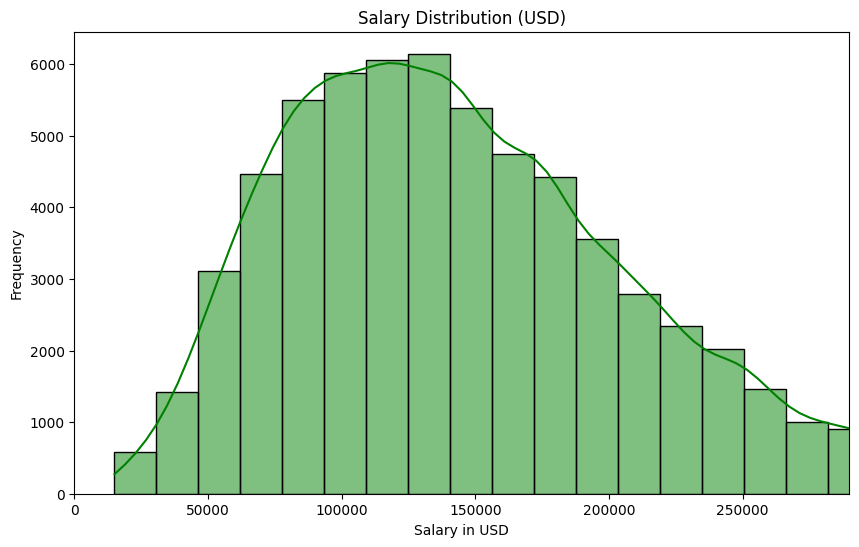

In [69]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(df['salary_in_usd'], bins=50, kde=True, color="Green")
plt.title('Salary Distribution (USD)')
plt.xlabel('Salary in USD')
plt.ylabel('Frequency')
plt.xlim(0, df['salary_in_usd'].quantile(0.95))  # cut outliers
plt.show()


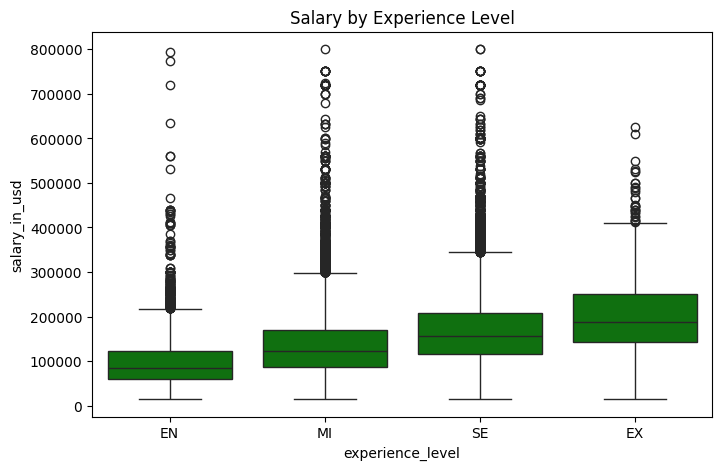

In [70]:
plt.figure(figsize=(8, 5))
sns.boxplot(x='experience_level', y='salary_in_usd', data=df, order=['EN', 'MI', 'SE', 'EX'], color="Green") # Entry level to executive level
plt.title('Salary by Experience Level')
plt.show()


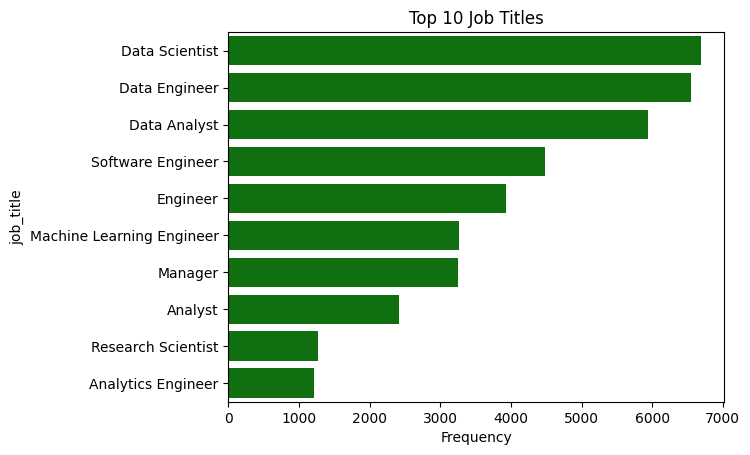

In [71]:
top_jobs = df['job_title'].value_counts().head(10)
sns.barplot(y=top_jobs.index, x=top_jobs.values, color="Green")
plt.title('Top 10 Job Titles')
plt.xlabel('Frequency')
plt.show()


### Remote Work vs Salary
The results below bring hope to my inquiry, showing a similar distribution between 0% remote and 100% remote.

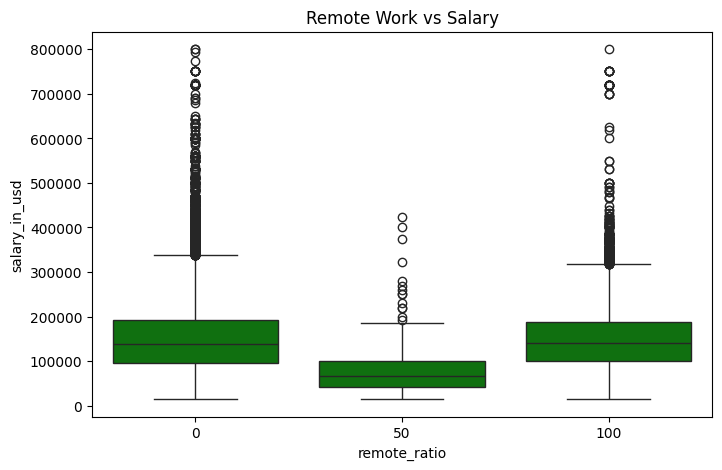

In [72]:
plt.figure(figsize=(8, 5))
sns.boxplot(x='remote_ratio', y='salary_in_usd', data=df, color="Green")
plt.title('Remote Work vs Salary')
plt.show()


# Models
Here we begin work on our models.  I decided to start with a Random Forest model due to its strength with noisy data.  The main goal here is to get a baseline and identify feature importance.

In [41]:
features = ['experience_level', 'employment_type', 'job_title', 'employee_residence',
            'remote_ratio', 'company_location', 'company_size']

X = df[features].copy()
y = df['salary_in_usd']

for col in X.select_dtypes(include='object').columns:
    X[col] = LabelEncoder().fit_transform(X[col])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [61]:
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("==============================================")
print("R2 Score:", r2_score(y_test, y_pred))
print("RMSE:", root_mean_squared_error(y_test, y_pred), "\n==============================================")

R2 Score: 0.2750840159911766
RMSE: 66856.57249860848 


The low score indicates that much of salary variability remains unexplained.  This remained despite tuning and is likely due to external factors not captured in this dataset.  I believe that the unsupervised model will be able to make use of these hidden aspects since it will not be reliant upon the limited factors present.

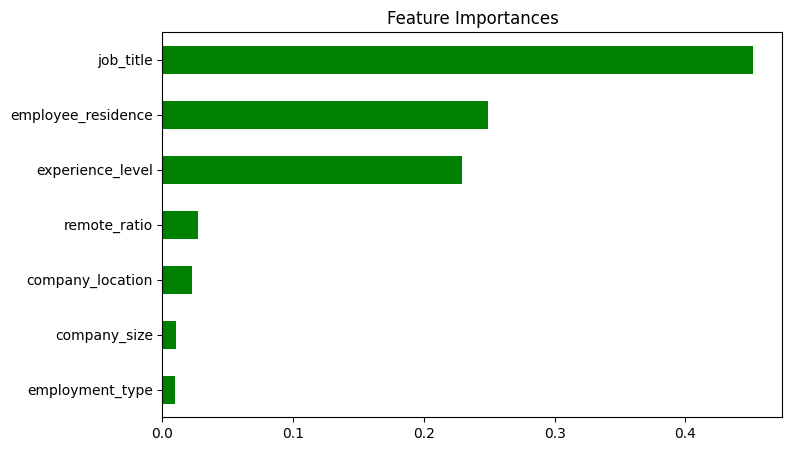

In [73]:
importances = pd.Series(model.feature_importances_, index=X.columns) # Feature Importance
importances.sort_values().plot(kind='barh', figsize=(8, 5), title="Feature Importances", color="Green")
plt.show()

### KMeans 
This models won’t suffer from noisy or missing labels. This makes it a great option for more real-world oriented datasets like this one.

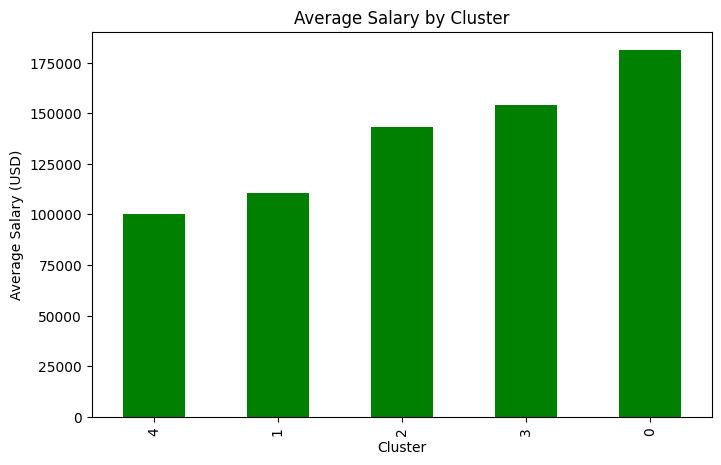

In [74]:
X_scaled = StandardScaler().fit_transform(X)

kmeans = KMeans(n_clusters=5, random_state=42)
df['cluster'] = kmeans.fit_predict(X_scaled)

cluster_avg_salary = df.groupby('cluster')['salary_in_usd'].mean().sort_values() # Visualize clusters by average salary
cluster_avg_salary.plot(kind='bar', figsize=(8, 5), title="Average Salary by Cluster", color="Green")
plt.ylabel("Average Salary (USD)")
plt.xlabel("Cluster")
plt.show()


In [60]:
cluster_0 = df[df['cluster'] == 0] # Compare cluster 0 to others
other_clusters = df[df['cluster'] != 0]

print("==============================================\nExperience levels in Cluster 0:\n", cluster_0['experience_level'].value_counts())
print("==============================================\nTop job titles in Cluster 0:\n", cluster_0['job_title'].value_counts().head(10), "\n==============================================")

Experience levels in Cluster 0:
 experience_level
SE    10217
MI     6162
EN      997
EX      438
Name: count, dtype: int64
Top job titles in Cluster 0:
 job_title
Software Engineer                2970
Engineer                         2368
Manager                          2211
Machine Learning Engineer        2008
Research Scientist                979
Product Manager                   810
Research Engineer                 679
Systems Engineer                  414
Engineering Manager               321
Software Development Engineer     311
Name: count, dtype: int64 


In [59]:
print("==============================================\nRemote work in Cluster 0:\n", cluster_0['remote_ratio'].value_counts())
print("==============================================\nCompany locations in Cluster 0:\n", cluster_0['company_location'].value_counts().head(10), "\n==============================================")

Remote work in Cluster 0:
 remote_ratio
0     17789
50       25
Name: count, dtype: int64
Company locations in Cluster 0:
 company_location
US    17551
NL       66
LT       54
LV       30
PL       28
SK       21
PT       11
SG       10
MT        8
ZA        7
Name: count, dtype: int64 


In [58]:
print("==============================================\nExperience levels in other_clusters:\n", other_clusters['experience_level'].value_counts())
print("==============================================\nRemote work in other_clusters:\n", other_clusters['remote_ratio'].value_counts())
print("==============================================\nCompany locations in other_clusters:\n", other_clusters['company_location'].value_counts().head(10), "\n==============================================")

Experience levels in other_clusters:
 experience_level
SE    23781
MI    14747
EN     6403
EX     1878
Name: count, dtype: int64
Remote work in other_clusters:
 remote_ratio
0      30754
100    15763
50       292
Name: count, dtype: int64
Company locations in other_clusters:
 company_location
US    36702
CA     3968
GB     2555
AU      452
DE      350
NL      278
FR      263
LT      235
IN      187
ES      184
Name: count, dtype: int64 


In [57]:
print("==============================================\nTop job titles in other_clusters:\n", other_clusters['job_title'].value_counts().head(20), "\n==============================================")

Top job titles in other_clusters:
 job_title
Data Scientist                   6640
Data Engineer                    6555
Data Analyst                     5945
Analyst                          2417
Engineer                         1564
Software Engineer                1508
Machine Learning Engineer        1260
Analytics Engineer               1216
Data Architect                   1138
Associate                        1110
Manager                          1043
AI Engineer                       979
Consultant                        692
Data Manager                      649
Data Specialist                   602
Applied Scientist                 524
Business Intelligence Analyst     505
Architect                         443
Developer                         421
Product Manager                   368
Name: count, dtype: int64 


### Conclusion
Higher salaries seem to be clustered in senior, on-site, U.S.-based software/engineering roles.  Experience and geography stand out the most umong these.  Unfortunately the clustering of top pay acording to our model indicates a preference in non-remote roles.  The biggest takeaways we can gather from the highest paid cluster are as follows:

* Vast majority are US based
* Experience level plays a large impact
    * The lower lever of entry level in the other clusters may indicate missing data or worse a significant reduction in entry level positions
* Software Engineer and ML Engineer seem to be the most prominenet
* Very low remote ratio
* Though we saw earlier that data roles were more common, they fall behind engineer roles in pay
